In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import torchvision

In [ ]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())


PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA is available: True


In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [5]:
image = cv2.imread('Dataset/Corner-kick/ck_image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

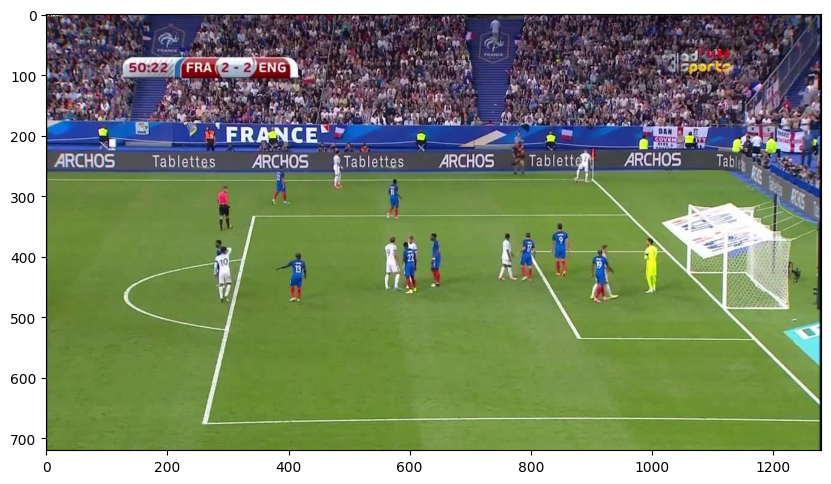

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [11]:

from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

d:\yutol\T2I-soccer-cornerkick-freekick\T2IEnv\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [12]:
predictor.set_image(image)

In [13]:
image.shape

(720, 1280, 3)

In [20]:
input_point = np.array([[415, 420]])
input_label = np.array([1])

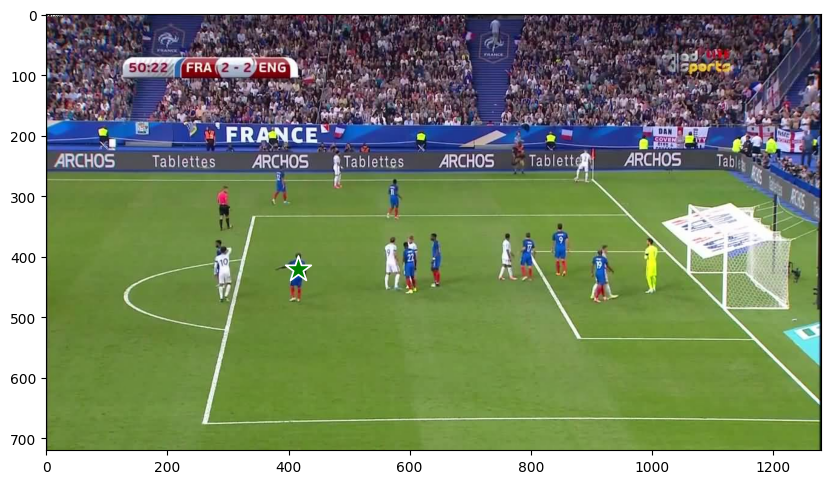

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [22]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

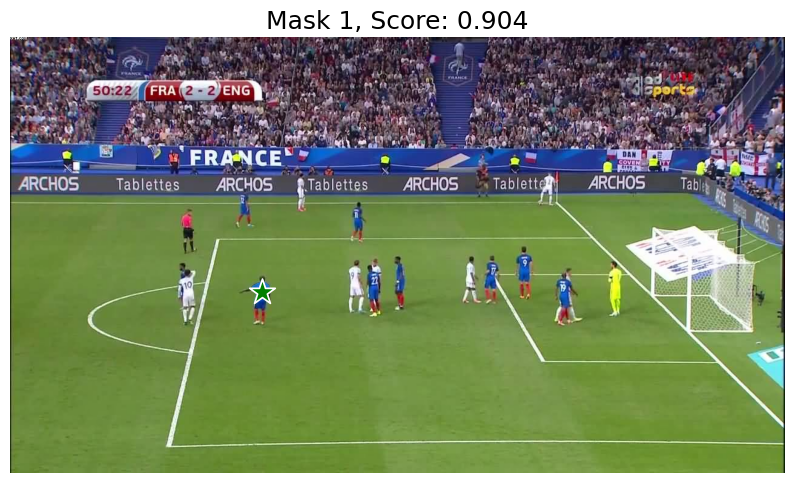

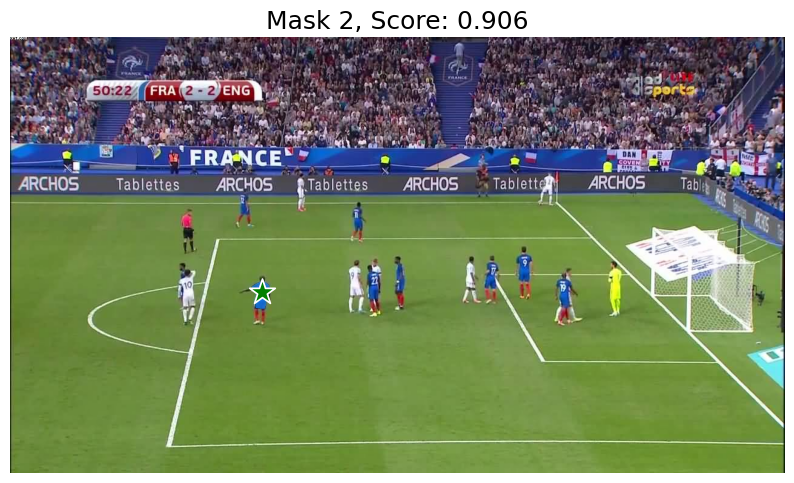

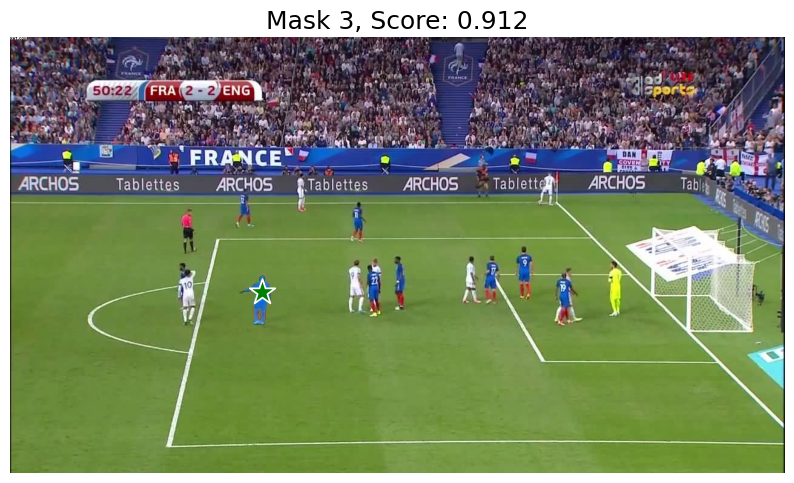

In [24]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [45]:
input_box = np.array([375, 385, 435, 480])

In [46]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

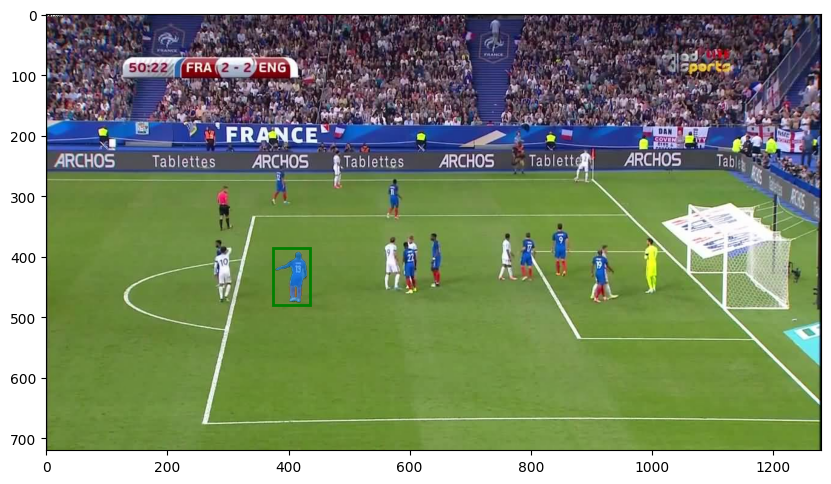

In [47]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('on')
plt.show()

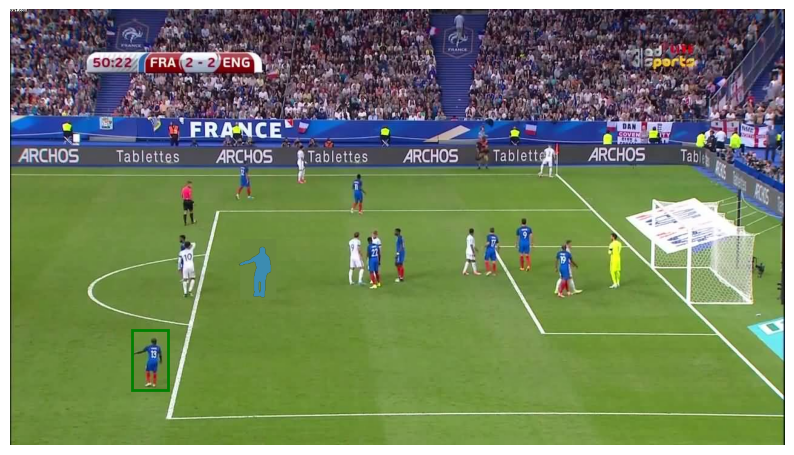

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Function to move the object and cover the original area with the surrounding environment
def move_object_and_cover_with_surrounding(image, input_box, max_offset=50, sample_area_size=50):
    x0, y0, x1, y1 = input_box
    # Extract the object (ROI) inside the bounding box
    object_roi = image[y0:y1, x0:x1]
    
    # Sample the color from a nearby area (around the original bounding box) to match the environment
    sample_x0 = max(0, x0 - sample_area_size)
    sample_y0 = max(0, y0 - sample_area_size)
    sample_x1 = min(image.shape[1], x1 + sample_area_size)
    sample_y1 = min(image.shape[0], y1 + sample_area_size)
    
    # Extract a sample area from the image
    sample_area = image[sample_y0:sample_y1, sample_x0:sample_x1]
    
    # Calculate the average color from the sampled area (mean of pixels)
    surrounding_color = np.mean(sample_area, axis=(0, 1)).astype(np.uint8)
    
    # Create a copy of the image and cover the original area with the surrounding color
    image_with_surrounding = image.copy()
    image_with_surrounding[y0:y1, x0:x1] = surrounding_color
    
    # Randomly choose a new position for the object inside the image bounds
    new_x0 = np.random.randint(0, image.shape[1] - (x1 - x0))
    new_y0 = np.random.randint(0, image.shape[0] - (y1 - y0))
    
    # Define the new bounding box for the object
    new_x1 = new_x0 + (x1 - x0)
    new_y1 = new_y0 + (y1 - y0)
    
    # Place the object at the new location on the image
    image_with_surrounding[new_y0:new_y1, new_x0:new_x1] = object_roi
    
    return image_with_surrounding, np.array([new_x0, new_y0, new_x1, new_y1])

# Specify your original input box
input_box = np.array([380, 380, 440, 480])

# Perform prediction using the input box
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

# Move the object inside the bounding box and cover original position with surrounding color
moved_image, moved_box = move_object_and_cover_with_surrounding(image, input_box, max_offset=50)

# Plot the image and visualize the moved object and the new bounding box
plt.figure(figsize=(10, 10))
plt.imshow(moved_image)
show_mask(masks[0], plt.gca())
show_box(moved_box, plt.gca())  # Show the moved bounding box
plt.axis('off')
plt.show()
